In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yahoofinance-dataset/yahoo_data.xlsx


# **Step 1: Download and Preprocess Historical Stock Price Data**

## **Objective:**
#### Get stock data from Yahoo Finance for a few companies (e.g., AAPL, TSLA, AMZN)         and prepare it for analysis.

## **1.1 – Import Required Libraries**

In [8]:
# STEP 1.1: Importing libraries

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

# Set plot style
plt.style.use("seaborn-v0_8-darkgrid")

## **1.2 – Download Data from Yahoo Finance**

In [19]:
# STEP 1.2: Load your single‑series Excel snapshot

import pandas as pd
import os

# 1) Path to Excel file
excel_path = "/kaggle/input/yahoofinance-dataset/yahoo_data.xlsx"

# 2) Read the only sheet and parse the Date column
full_df = pd.read_excel(
    excel_path,
    sheet_name="Sheet1",
    parse_dates=["Date"]
)

# 3) Rename columns to standard OHLCV names
full_df.rename(
    columns={
        "Close*":     "Close",
        "Adj Close**":"Adj Close"
    },
    inplace=True
)

# 4) Assign a dummy Ticker so our pipeline stays uniform
full_df["Ticker"] = "YAHOO"

# 5) Quick sanity check
print("Columns:",    full_df.columns.tolist())
print("Date range:", full_df.Date.min().date(), "→", full_df.Date.max().date())
print("Rows:",       full_df.shape[0])
print(full_df.head())

# 6) Save out as a checkpoint CSV
os.makedirs("raw_data", exist_ok=True)
checkpoint_path = "raw_data/yahoo_stock.csv"
full_df.to_csv(checkpoint_path, index=False)
print(f"Saved checkpoint to {checkpoint_path}")

# 7) Prepare stock_data dict for downstream steps
stock_data = {"YAHOO": full_df}

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']
Date range: 2018-05-01 → 2023-04-28
Rows: 1258
        Date      Open      High       Low     Close  Adj Close     Volume  \
0 2023-04-28  33797.43  34104.56  33728.40  34098.16   34098.16  354310000   
1 2023-04-27  33381.66  33859.75  33374.65  33826.16   33826.16  343240000   
2 2023-04-26  33596.34  33645.83  33235.85  33301.87   33301.87  321170000   
3 2023-04-25  33828.34  33875.49  33525.39  33530.83   33530.83  297880000   
4 2023-04-24  33805.04  33891.15  33726.09  33875.40   33875.40  252020000   

  Ticker  
0  YAHOO  
1  YAHOO  
2  YAHOO  
3  YAHOO  
4  YAHOO  
Saved checkpoint to raw_data/yahoo_stock.csv


### **1.3 – Combine and Visualize the Data**

First 5 rows:
                 Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2018-05-01  24117.29  24117.29  23808.19  24099.05   24099.05  380070000   
2018-05-02  24097.63  24185.52  23886.30  23924.98   23924.98  385350000   
2018-05-03  23836.23  23996.15  23531.31  23930.15   23930.15  389240000   
2018-05-04  23865.22  24333.35  23778.87  24262.51   24262.51  329480000   
2018-05-07  24317.66  24479.45  24263.42  24357.32   24357.32  307670000   

           Ticker  
Date               
2018-05-01  YAHOO  
2018-05-02  YAHOO  
2018-05-03  YAHOO  
2018-05-04  YAHOO  
2018-05-07  YAHOO   

Last  5 rows:
                 Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2023-04-24  33805.04  33891.15  33726.09  33875.40   33875.40  252020000   
2023-04-25  33828.34  33875.49  33525.39  33530.83   33530.83  2978

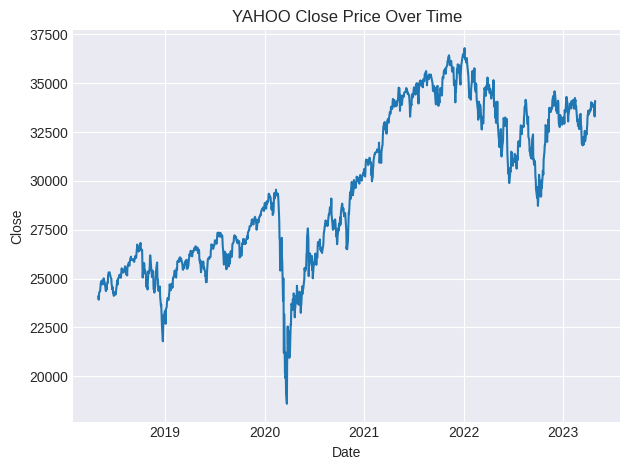

In [20]:
# STEP 1.3: Prepare & visualize your combined DataFrame

import pandas as pd
import matplotlib.pyplot as plt
import os

# 1) Retrieve DataFrame from stock_data
combined_df = stock_data["YAHOO"].copy()

# 2) Ensure it’s sorted by Date and that Date is a column
combined_df.sort_values("Date", inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# 3) Make Date the index for time‑series ops
combined_df.set_index("Date", inplace=True)

# 4) Inspect the first and last few rows
print("First 5 rows:\n", combined_df.head(), "\n")
print("Last  5 rows:\n", combined_df.tail(), "\n")
print("Shape:", combined_df.shape)

# 5) Quick plot of Close price to verify continuity
plt.figure()                     # new figure
plt.plot(combined_df["Close"])   # time‑series line
plt.title("YAHOO Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close")
plt.tight_layout()
plt.show()

# **Step 2: Plot Technical Indicators** 

In [22]:
# Calculate indicators before plotting

# 1. Simple Moving Average (SMA)
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# 2. Exponential Moving Average (EMA)
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# 3. Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.ewm(span=14, adjust=False).mean()
avg_loss = loss.ewm(span=14, adjust=False).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 4. Bollinger Bands
rolling_mean = df['Close'].rolling(window=20).mean()
rolling_std  = df['Close'].rolling(window=20).std()
df['BB_upper'] = rolling_mean + (2 * rolling_std)
df['BB_lower'] = rolling_mean - (2 * rolling_std)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


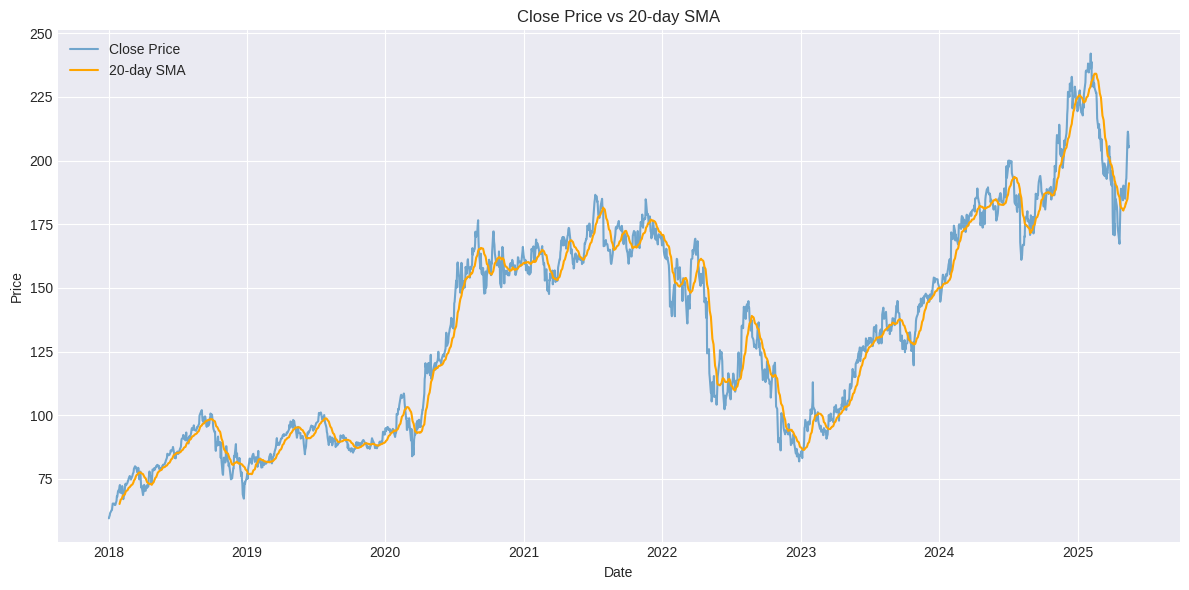

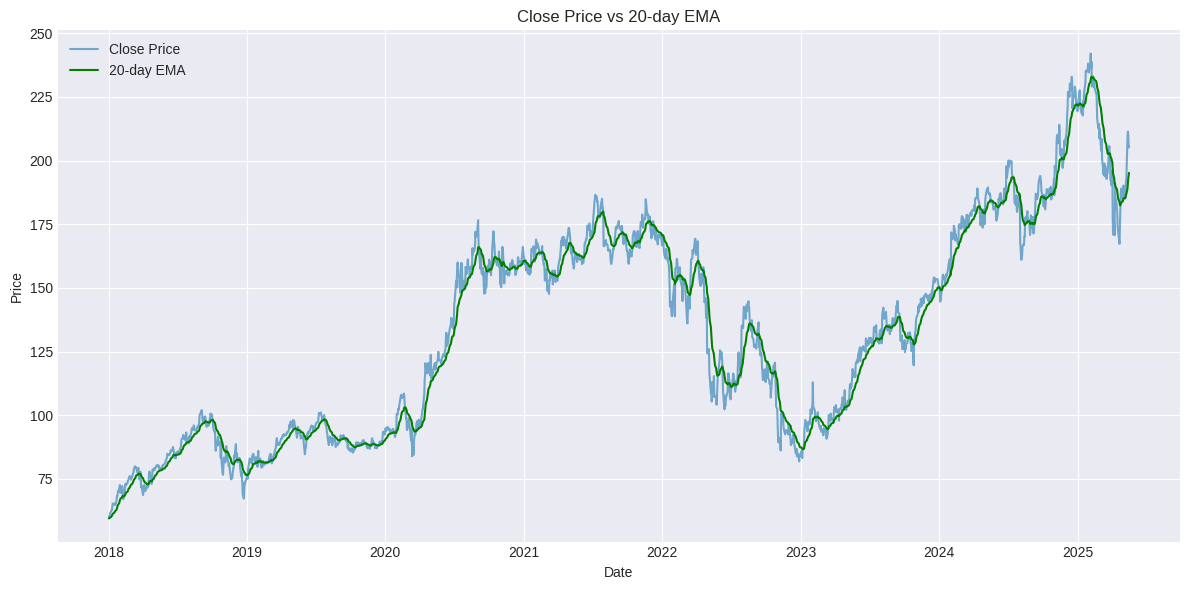

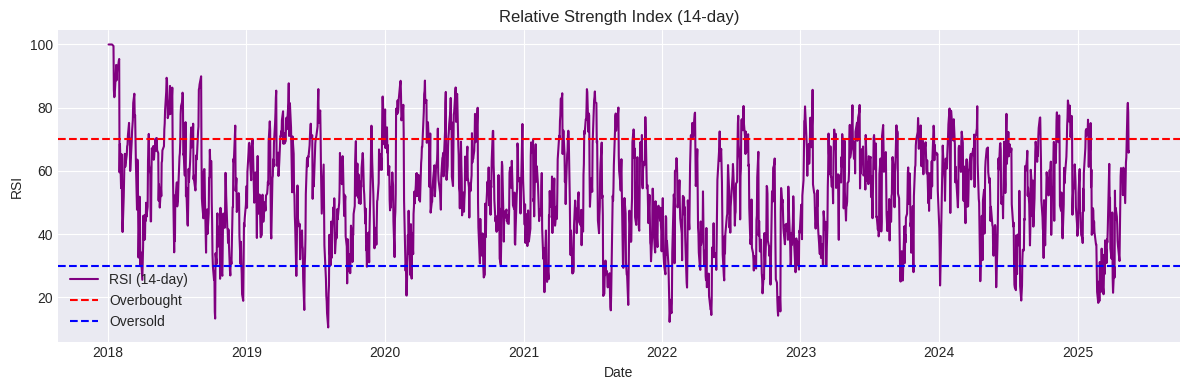

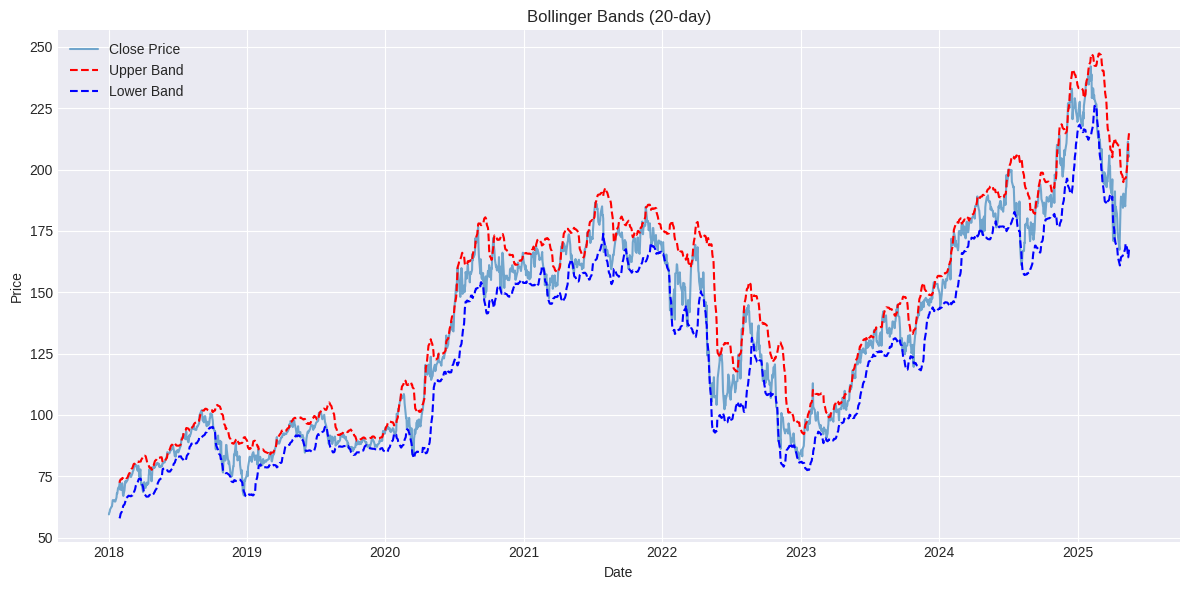

In [23]:
# Plot 1: Close Price with 20-day SMA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.6)
plt.plot(df.index, df['SMA_20'], label='20-day SMA', color='orange')
plt.title("Close Price vs 20-day SMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Close Price with 20-day EMA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.6)
plt.plot(df.index, df['EMA_20'], label='20-day EMA', color='green')
plt.title("Close Price vs 20-day EMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: 14-day RSI
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['RSI_14'], label='RSI (14-day)', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='blue', label='Oversold')
plt.title("Relative Strength Index (14-day)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 4: Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.6)
plt.plot(df.index, df['BB_upper'], label='Upper Band', linestyle='--', color='red')
plt.plot(df.index, df['BB_lower'], label='Lower Band', linestyle='--', color='blue')
plt.title("Bollinger Bands (20-day)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Step 3: Clean Data + Unsupervised Anomaly Detection**

### **3.1 — Data Cleaning**

In [24]:
# STEP 3.1: DATA CLEANING

# Drop rows with any NaNs from rolling calculations (SMA, RSI, etc.)
df_cleaned = df.dropna()

df_cleaned.reset_index(inplace=True)

# Verify shape and missing values
print("Data shape after cleaning:", df_cleaned.shape)
print("\nMissing values:\n", df_cleaned.isnull().sum())

Data shape after cleaning: (1835, 12)

Missing values:
 Price     Ticker
Date                0
Close     AMZN      0
High      AMZN      0
Low       AMZN      0
Open      AMZN      0
Volume    AMZN      0
Ticker              0
SMA_20              0
EMA_20              0
RSI_14              0
BB_upper            0
BB_lower            0
dtype: int64


### **3.2 - Unsupervised Anomaly Detection using Isolation Forest**

We’ll use Isolation Forest to identify anomalies in stock behavior based on:
     
* Price action (Open, High, Low, Close, Volume)
* Technical indicators (SMA, EMA, RSI, Bollinger Bands)


In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# STEP 3.2: Unsupervised Anomaly Detection with Isolation Forest

# Select features
features = ['Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_upper', 'BB_lower']
X = df_cleaned[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
df_cleaned['anomaly'] = iso_forest.fit_predict(X_scaled)

# Isolation Forest returns:
#   1 → normal
#  -1 → anomaly
df_cleaned['anomaly'] = df_cleaned['anomaly'].map({1: 0, -1: 1})  # make it 0: normal, 1: anomaly

# Show how many anomalies
print("Number of anomalies detected:", df_cleaned['anomaly'].sum())

Number of anomalies detected: 37


/tmp/ipykernel_102/2568665953.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['anomaly'] = iso_forest.fit_predict(X_scaled)
/tmp/ipykernel_102/2568665953.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['anomaly'] = df_cleaned['anomaly'].map({1: 0, -1: 1})  # make it 0: normal, 1: anomaly


### **3.3 — Visualize Detected Anomalies on the Price Trend**
Anomalies will be marked with red dots so they’re easy to spot.

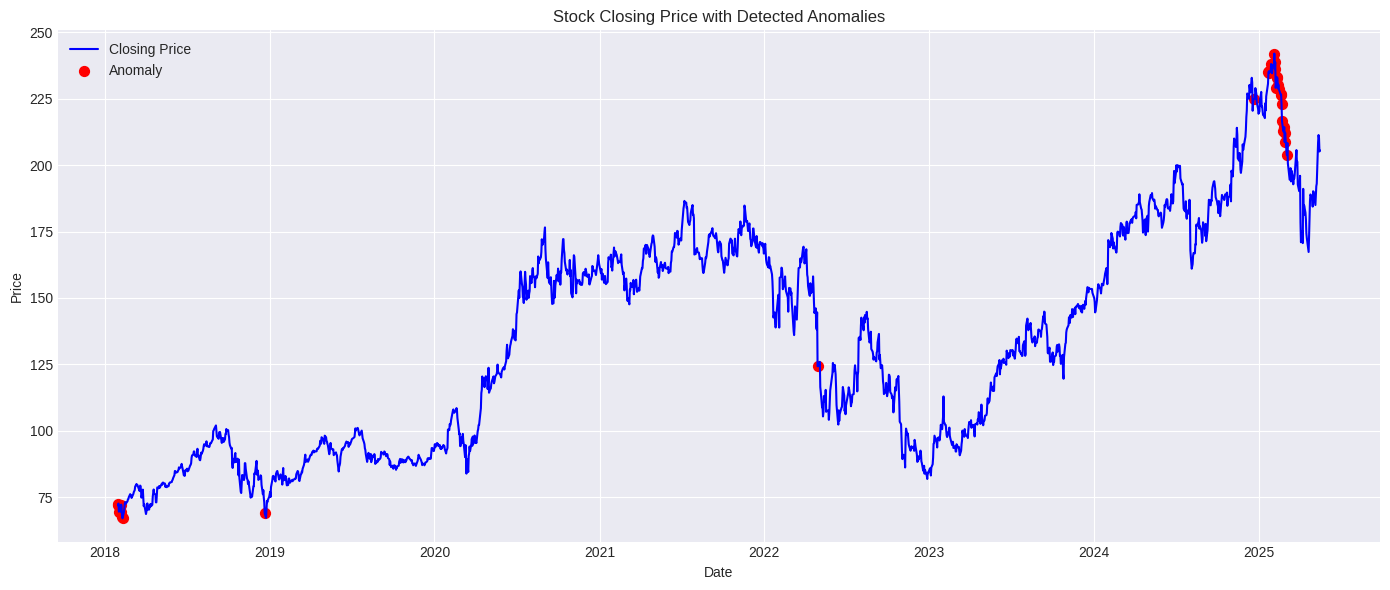

In [26]:
# STEP 3.3: Plot Closing Price with Anomalies

plt.figure(figsize=(14, 6))
plt.plot(df_cleaned['Date'], df_cleaned['Close'], label='Closing Price', color='blue')
plt.scatter(df_cleaned[df_cleaned['anomaly'] == 1]['Date'],
            df_cleaned[df_cleaned['anomaly'] == 1]['Close'],
            color='red', label='Anomaly', s=50)
plt.title('Stock Closing Price with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Step 4: Forecasting stock price behavior to identify future deviations from trends.**

### **Objective:**
#### We’ll build a time-series forecasting model using Prophet (by Meta/Facebook) to predict future stock prices and highlight when predicted values deviate significantly from the trend — potential signs of upcoming anomalies or market shifts.

#### Chose Prophet because it is simpler, quick to run, less data prep than LSTM.

### **4.1 — Prepare Data for Prophet**

#### Prophet expects only two columns:


* ds → datestamp (Date column)
* y → the value to forecast (e.g. Close price)


In [32]:
# If df_cleaned has a MultiIndex for columns (like ('Close', 'AMZN')), flatten it
if isinstance(df_cleaned.columns, pd.MultiIndex):
    df_cleaned.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_cleaned.columns]

# Confirm structure
print("Flattened columns:")
print(df_cleaned.columns.tolist())

Flattened columns:
['Date_', 'Close_AMZN', 'High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Volume_AMZN', 'Ticker_', 'SMA_20_', 'EMA_20_', 'RSI_14_', 'BB_upper_', 'BB_lower_', 'anomaly_']


In [38]:
import pandas as pd
from prophet import Prophet

# Choose ticker
ticker = 'AMZN'

# Build correct column names
date_col = 'Date_'
close_col = f'Close_{ticker}'

# Select and rename columns for Prophet
df_prophet = df_cleaned[[date_col, close_col]].copy()
df_prophet.rename(columns={date_col: 'ds', close_col: 'y'}, inplace=True)

# Ensure correct data types
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

# Drop missing
df_prophet.dropna(subset=['ds', 'y'], inplace=True)

# Check structure
print(df_prophet.dtypes)
print(df_prophet.head())

ds    datetime64[ns]
y            float64
dtype: object
          ds          y
0 2018-01-30  71.890999
1 2018-01-31  72.544502
2 2018-02-01  69.500000
3 2018-02-02  71.497498
4 2018-02-05  69.500000


### **4.2 — Fit Prophet Model and Forecast**

#### We’ll:


* Fit the model on historical closing prices
* Forecast the next 60 business days


21:24:06 - cmdstanpy - INFO - Chain [1] start processing
21:24:07 - cmdstanpy - INFO - Chain [1] done processing


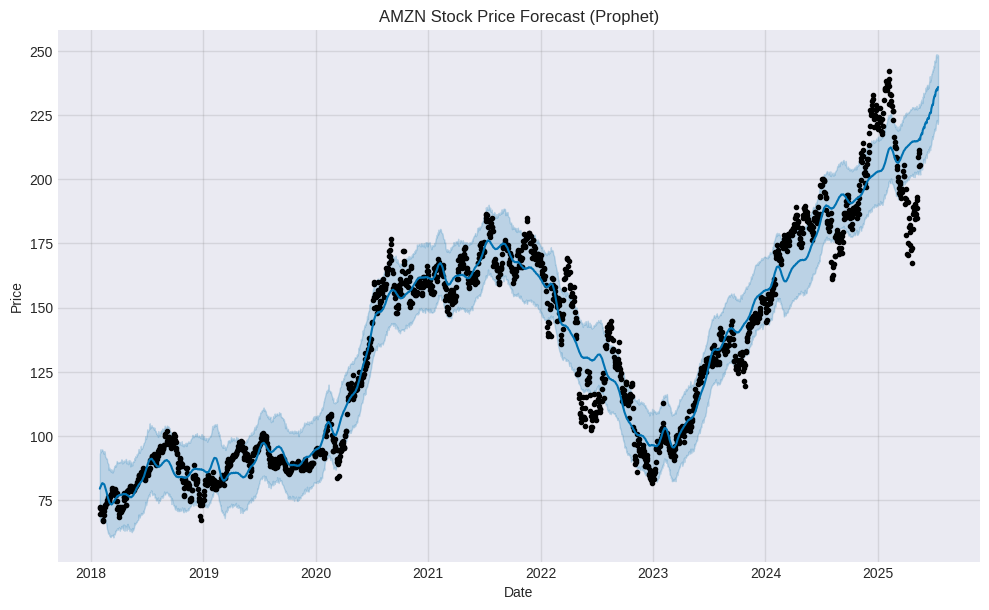

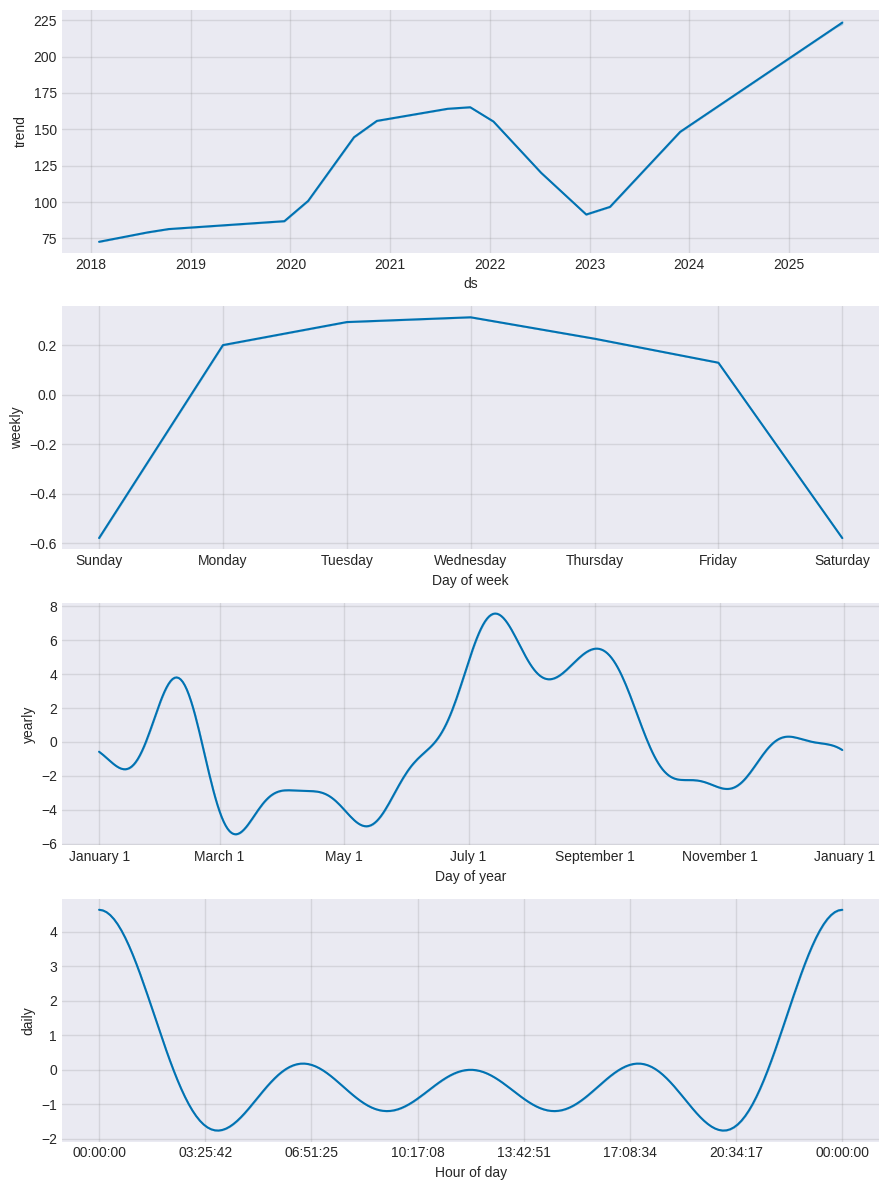

In [39]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize and fit the model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Create future dataframe for 60 days
future = model.make_future_dataframe(periods=60)

# Predict
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("AMZN Stock Price Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Plot forecast components (Trend, Weekly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

# **Step 5: Visualize Both Anomalies and Forecast**

### **Objective:** 
#### We want a final plot showing:

##### Historical AMZN stock price

##### Detected anomalies

##### Forecasted trend

##### Confidence intervals to reflect the uncertainty of future predictions

### **5.1: Merge Historical Data with Forecast for Unified Plot**

In [40]:
import pandas as pd

# Merge historical anomalies into Prophet forecast
merged_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    df_cleaned[['Date_', 'Close_AMZN', 'anomaly_']],
    left_on='ds', right_on='Date_',
    how='left'
)

 ### **5.2: Final Visualization**

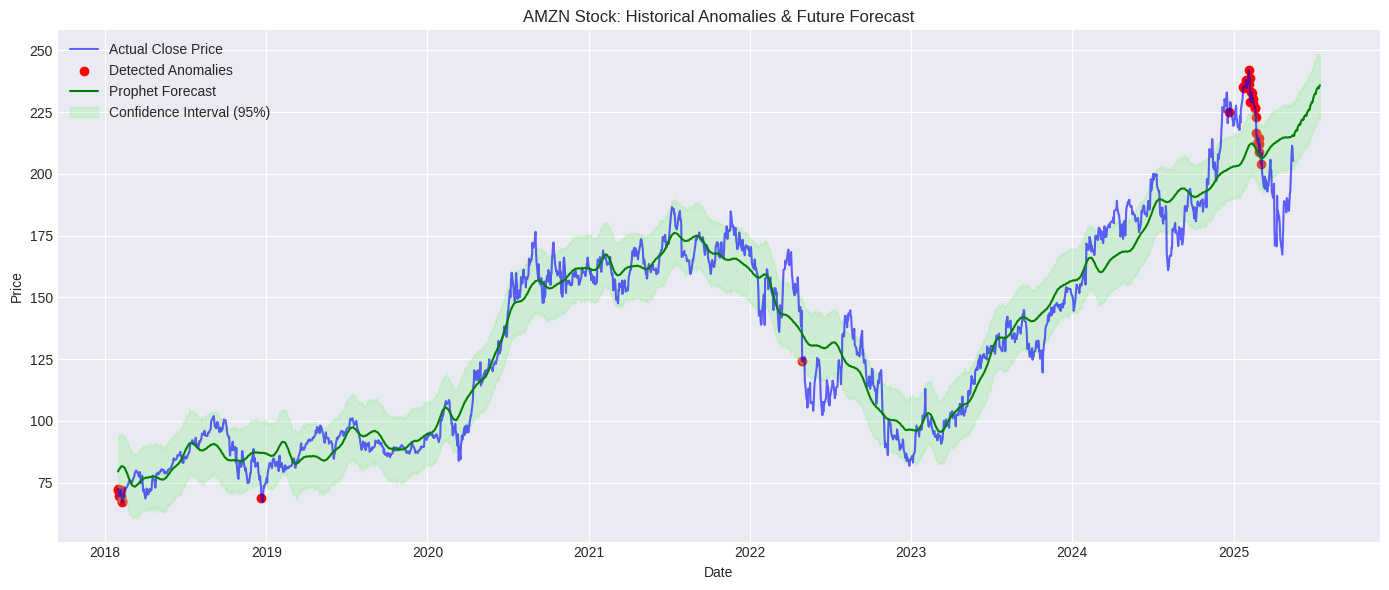

In [41]:
plt.figure(figsize=(14, 6))

# Plot actual stock price
plt.plot(merged_df['ds'], merged_df['Close_AMZN'], label='Actual Close Price', color='blue', alpha=0.6)

# Plot anomalies as red dots
anomaly_points = merged_df[merged_df['anomaly_'] == 1]
plt.scatter(anomaly_points['ds'], anomaly_points['Close_AMZN'], color='red', label='Detected Anomalies')

# Plot forecast line
plt.plot(merged_df['ds'], merged_df['yhat'], label='Prophet Forecast', color='green')

# Confidence interval
plt.fill_between(merged_df['ds'], merged_df['yhat_lower'], merged_df['yhat_upper'],
                 color='lightgreen', alpha=0.3, label='Confidence Interval (95%)')

plt.title("AMZN Stock: Historical Anomalies & Future Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **What We’ll See:**


* **Blue line:** Actual AMZN stock closing price.
* **Red dots:** Detected anomalies (sudden spikes/drops).
* **Green line:** Forecasted future trend using Prophet.
* **Green shaded area:** Prophet’s 95% confidence interval.
